<a href="https://colab.research.google.com/github/muhafidz-ahmad/credit-risk-prediction-vix-idx-partners/blob/main/Credit_Risk_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Risk Prediction ID/X Partners

## Persiapan Package dan Data

In [1]:
import re
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

from scipy.stats import shapiro

import sklearn
import pickle

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Real Portofolio/Credit Risk Prediction VIX ID X Partners/loan_data_2007_2014.csv")
df.sample(5)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
14283,14283,762290,962802,24575,24575,24325.0,60 months,13.49,565.35,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
323812,323812,24725033,27168041,9600,9600,9600.0,36 months,10.15,310.45,B,...,NaN,NaN,NaN,NaN,NaN,NaN,21200.0,NaN,NaN,NaN
11406,11406,815541,1023210,5600,5600,5600.0,36 months,10.99,183.32,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27961,27961,546490,704705,9000,9000,8875.0,36 months,7.51,280.00,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106687,106687,6522103,8074067,24000,24000,24000.0,36 months,6.62,736.89,A,...,NaN,NaN,NaN,NaN,NaN,NaN,59500.0,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

Terdapat kolom index yang tidak terpakai dan beberapa kolom yang tidak memiliki nilai sama sekali. Maka kolom-kolom tersebut akan dihapus agar proses lebih analisis lebih sederhana.

In [4]:
df.drop(df.isnull().sum()[lambda x: x == df.shape[0]].index, 
        axis=1, inplace=True)

## Data Understanding

Masih terdapat banyak sekali kolom pada dataset. Bisa jadi terdapat kolom-kolom yang tidak terpakai untuk melakukan prediksi risiko kredit.

In [5]:
def info(df):
  col_understanding = ['nama_kolom', 'tipe_data', 'null',
                       'nilai_unik', 'sampel_nilai']
  understanding_list = list()

  for i in df.columns:
    kolom = []
    kolom.append(i)
    kolom.append(df[i].dtype)
    kolom.append(df[i].isnull().sum())
    jumlah_nilai_unik = len(df[i].unique())
    kolom.append(jumlah_nilai_unik)
    if jumlah_nilai_unik >= 10:
      #kolom.append(list(df[i].sample(10, random_state=845).values))
      kolom.append(list(df[i].unique()[:10]))
    else:
      kolom.append(list(df[i].unique()))

    understanding_list.append(kolom)

  return pd.DataFrame(understanding_list, columns=col_understanding)

understanding_df = info(df)
path = '/content/drive/MyDrive/Colab Notebooks/Real Portofolio/Credit Risk Prediction VIX ID X Partners/'
file_undrstndng = 'Data Understanding Credit Risk Prediction (1).xlsx'
# understanding_df.to_excel(path+file_undrstndng, index=False)
# understanding_df

## Exploratory Data Analysis

In [6]:
unused_col = set()

Pertama, akan diperiksa jumlah null tiap kolom.

Terdapat 4 kolom yang memiliki nilai null lebih dari setengah total baris dataset, yaitu:
* mths_since_last_record
* mths_since_last_major_derog
* desc
* mths_since_last_delinq

Empat kolom tersebut akan dihapus.

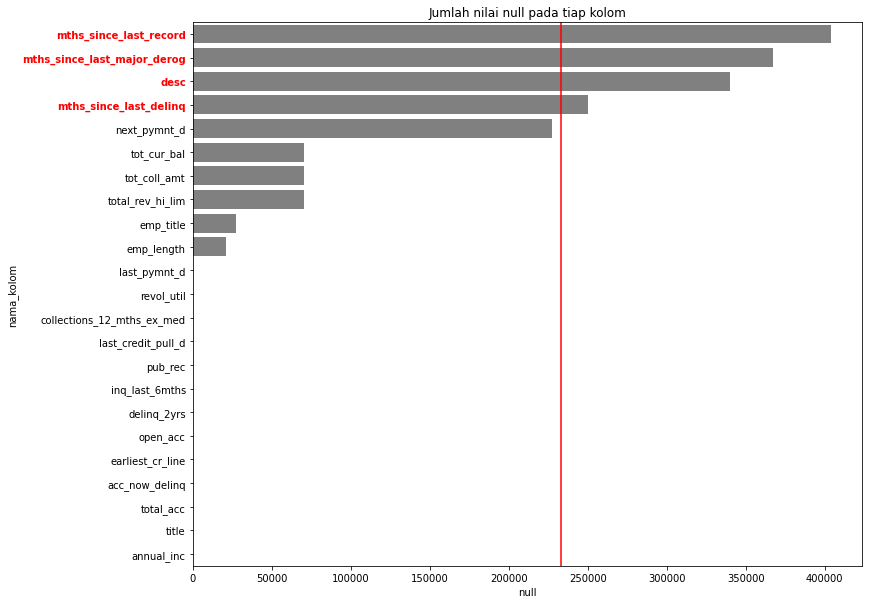

In [7]:
# Periksa jumlah nilai null tiap kolom
understanding_df.sort_values('null', axis=0, inplace=True, ascending=False)

plt.figure(figsize=(12,10))
ax = sns.barplot(data=understanding_df[understanding_df['null'] != 0],
                 x='null', y='nama_kolom', color='grey')
plt.axvline(x=df.shape[0]/2, color='r', label='1/2 total baris')
plt.title('Jumlah nilai null pada tiap kolom')

for i, label in enumerate(ax.get_yticklabels()):
    if understanding_df.reset_index().loc[i, 'null'] > df.shape[0]/2:
        label.set_weight("bold")
        label.set_color("red")
    else:
        label.set_color("black")

del_col = understanding_df[understanding_df['null'] > df.shape[0]/2]['nama_kolom']
for col in del_col:
  unused_col.add(col)

df.drop(del_col, axis=1, inplace=True)

understanding_df = understanding_df[understanding_df['null'] <= df.shape[0]/2]

Selanjutnya akan diperiksa jumlah nilai unik pada tiap kolom.

Terdapat 4 kolom yang terlalu unik dimana jumlah nilai uniknya sama dengan total kolom, yaitu:
* Unnamed: 0
* url
* member_id
* id

Empat kolom tersebut akan dihapus.

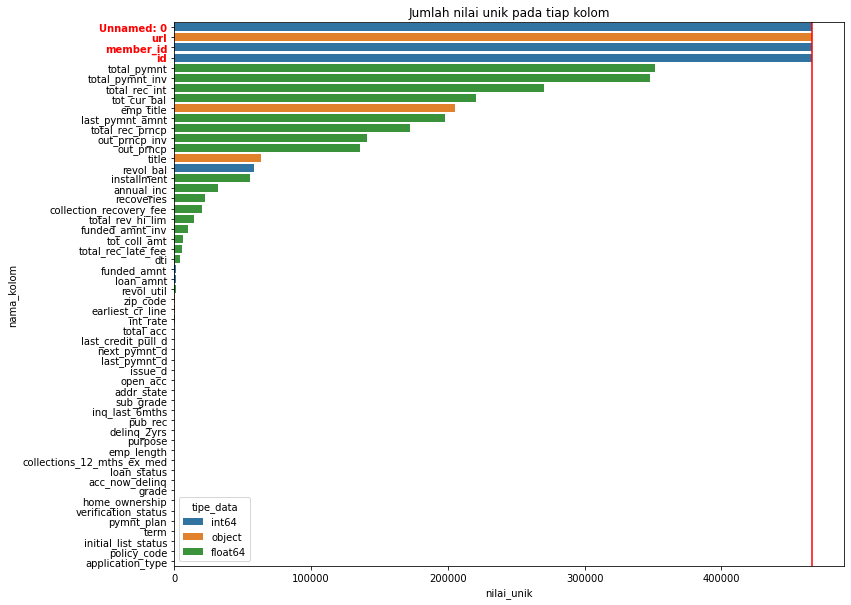

In [8]:
# Periksa jumlah nilai unik tiap kolom
understanding_df.sort_values('nilai_unik', axis=0, inplace=True, ascending=False)

plt.figure(figsize=(12,10))
ax = sns.barplot(data=understanding_df,
                 x='nilai_unik', y='nama_kolom', hue='tipe_data', dodge=False)
plt.axvline(x=df.shape[0], color='r')
plt.title('Jumlah nilai unik pada tiap kolom')

for i, label in enumerate(ax.get_yticklabels()):
    if understanding_df.reset_index().loc[i, 'nilai_unik'] == df.shape[0]:
        label.set_weight("bold")
        label.set_color("red")
    else:
        label.set_color("black")

del_col = understanding_df[understanding_df['nilai_unik'] == df.shape[0]]['nama_kolom']
for col in del_col:
  unused_col.add(col)

df.drop(del_col, axis=1, inplace=True)

understanding_df = understanding_df[understanding_df['nilai_unik'] < df.shape[0]]

### Status Pinjaman (Target)

Variabel target yang akan digunakan pada project credit risk prediction ini adalah *loan_statun* yang berisi status apakah peminjam melunasi pinjamannya atau tidak.

Text(0.5, 1.0, 'Jumlah kategori status pinjaman')

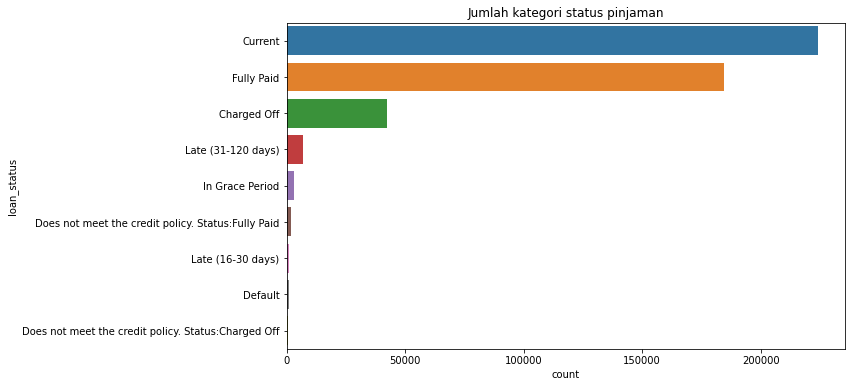

In [9]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, y='loan_status',
              order=df['loan_status'].value_counts().index)
plt.title('Jumlah kategori status pinjaman')

Pada project ini, akan dibuat sebuah model yang dapat memprediksi 2 risiko peminjam, yaitu:
* Risiko rendah, yang terdiri dari kategori *Fully Paid*. Akan direpresentasikan dengan 0.
* Risiko tinggi, yang terdiri dari kategori selain *Fully Paid*. Akan direpresentasikan dengan 1.

Sedangkan kategori *current* tidak akan digunakan karena kategori ini menunjukan peminjam sedang dalam masa cicilan pinjaman, yang artinya belum diketahui risikonya.

In [10]:
low_risk = ['Fully Paid']
high_risk = df['loan_status'].unique()
high_risk = high_risk[(high_risk != 'Fully Paid') & (high_risk != 'Current')]

def risk(col):
  if col in high_risk:
    return 1
  return 0

df = df[df['loan_status'] != 'Current']
df['loan_status'] = df['loan_status'].apply(risk)

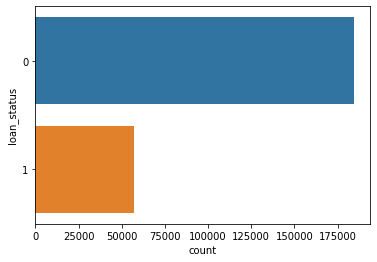

In [11]:
sns.countplot(data=df, y='loan_status')

## Exploratory Data Analysis 2

Kategori *Current* mengisi hampir setengah dari total baris pada data. Sehingga ketika baris dengan *loan_status* = *Current* dihapus, jumlah baris dataset berkurang drastis. 

Oleh karena itu akan diperiksa kembali kolom yang memiliki nilai null lebih dari setengah total baris.

Ditemukan 1 baris dengan jumlah nilai null lebih dari setengah total baris, yaitu *next_pymnt_d*. Kolom ini akan dihapus.

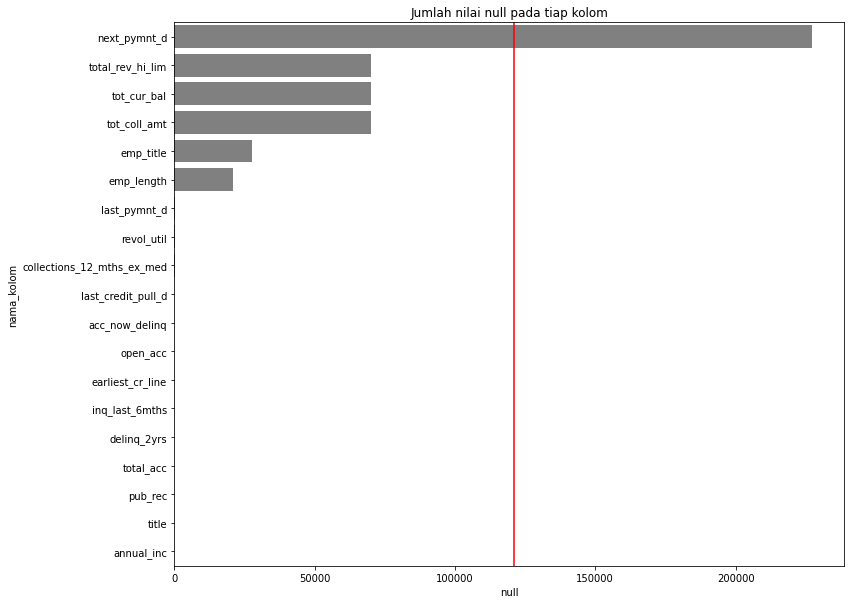

In [12]:
understanding_df.sort_values('null', axis=0, inplace=True, ascending=False)

plt.figure(figsize=(12,10))
sns.barplot(data=understanding_df[understanding_df['null'] != 0],
            x='null', y='nama_kolom', color='grey')
plt.axvline(x=df.shape[0]/2, color='r', label='1/2 total baris')
plt.title('Jumlah nilai null pada tiap kolom')

del_col = understanding_df[understanding_df['null'] > df.shape[0]/2]['nama_kolom']
for col in del_col:
  unused_col.add(col)

df.drop(del_col, axis=1, inplace=True)

understanding_df = understanding_df[understanding_df['null'] <= df.shape[0]/2]

Selanjutnya akan diperiksa nilai unik pada kolom dengan tipe data object.

Jika terdapat nilai unik yang sangat banyak pada suatu kolom dengan tipe data object, maka ini akan memberikan beban yang besar pada proses komputasi karena data objek ini akan diubah dengan teknik one hot encoding.

Jumlah nilai unik pada kolom dengan tipe data object akan dibatasi maksimal 100. 

Terdapat 5 kolom dengan nilai unik yang lebih dari 100, yaitu:
* emp_title
* title
* zip_code
* earliest_cr_line
* last_credit_pull_d

Lima kolom ini akan dihapus.

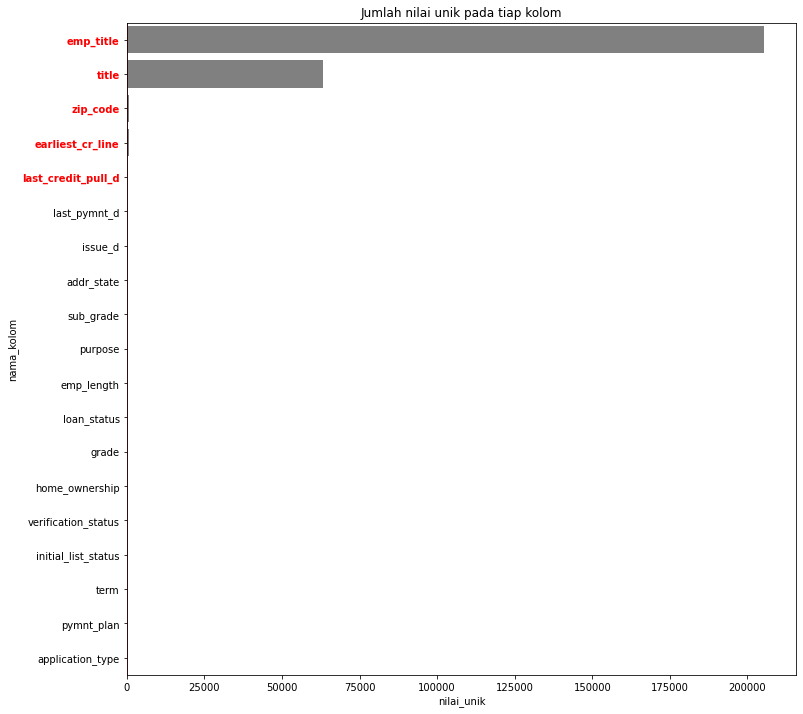

In [13]:
understanding_df.sort_values('nilai_unik', axis=0, 
                             inplace=True, ascending=False)

object_only = understanding_df[understanding_df['tipe_data'] == 'object']
object_only.reset_index(drop=True, inplace=True)

plt.figure(figsize=(12,12))
ax = sns.barplot(data=understanding_df[understanding_df['tipe_data'] == 'object'],
                 x='nilai_unik', y='nama_kolom', color='grey')
plt.axvline(x=100, color='r', label='1/2 total baris')
plt.title('Jumlah nilai unik pada tiap kolom')

for i, label in enumerate(ax.get_yticklabels()):
    if object_only.loc[i, 'nilai_unik'] >= 100:
        label.set_weight("bold")
        label.set_color("red")
    else:
        label.set_color("black")

del_col = object_only[object_only['nilai_unik'] > 100]['nama_kolom']
for col in del_col:
  unused_col.add(col)

df.drop(del_col, axis=1, inplace=True)

understanding_df = understanding_df[understanding_df['nilai_unik'] <= 100]

In [14]:
understanding_df

,nama_kolom,tipe_data,null,nilai_unik,sampel_nilai
46,last_pymnt_d,object,376,99,"[Jan-15, Apr-13, Jun-14, Jan-16, Apr-12, Nov-1..."
16,issue_d,object,0,91,"[Dec-11, Nov-11, Oct-11, Sep-11, Aug-11, Jul-1..."
31,open_acc,float64,29,63,"[3.0, 2.0, 10.0, 15.0, 9.0, 7.0, 4.0, 11.0, 14..."
24,addr_state,object,0,50,"[AZ, GA, IL, CA, OR, NC, TX, VA, MO, CT]"
10,sub_grade,object,0,35,"[B2, C4, C5, C1, B5, A4, E1, F2, C3, B1]"
28,inq_last_6mths,float64,29,29,"[1.0, 5.0, 2.0, 0.0, 3.0, 4.0, 6.0, 7.0, 8.0, ..."
32,pub_rec,float64,29,27,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, nan, 6.0, 9.0, ..."
26,delinq_2yrs,float64,29,25,"[0.0, 2.0, 3.0, 1.0, 4.0, 6.0, 5.0, 8.0, 7.0, ..."
21,purpose,object,0,14,"[credit_card, car, small_business, other, wedd..."
12,emp_length,object,21008,12,"[10+ years, < 1 year, 1 year, 3 years, 8 years..."


Terdapat 2 kolom yang hanya memiliki satu nilai unik, yaitu *policy_code* dan *application_type*. Kedua kolom ini tidak akan memberikan pengaruh terhadap prediksi. Sehingga kedua kolom tersebut akan dihapus.

In [15]:
del_col = object_only[object_only['nilai_unik'] == 1]['nama_kolom']
for col in del_col:
  unused_col.add(col)

df.drop(del_col, axis=1, inplace=True)

understanding_df = understanding_df[understanding_df['nilai_unik'] > 1]

### Eksplorasi variabel kategorik



In [16]:
understanding_df = info(df)
understanding_df[lambda x: x['tipe_data'] == 'object']

,nama_kolom,tipe_data,null,nilai_unik,sampel_nilai
3,term,object,0,2,"[ 36 months, 60 months]"
6,grade,object,0,7,"[B, C, A, E, F, D, G]"
7,sub_grade,object,0,35,"[B2, C4, C5, C1, A4, E1, F2, B5, C3, B1]"
8,emp_length,object,9327,12,"[10+ years, < 1 year, 3 years, 9 years, 4 year..."
9,home_ownership,object,0,6,"[RENT, OWN, MORTGAGE, OTHER, NONE, ANY]"
11,verification_status,object,0,3,"[Verified, Source Verified, Not Verified]"
12,issue_d,object,0,91,"[Dec-11, Nov-11, Oct-11, Sep-11, Aug-11, Jul-1..."
14,pymnt_plan,object,0,2,"[n, y]"
15,purpose,object,0,14,"[credit_card, car, small_business, other, wedd..."
16,addr_state,object,0,50,"[AZ, GA, IL, CA, TX, VA, MO, CT, UT, FL]"


Terdapat beberapa variabel dengan tipe data kategorik. 

* Variabel *last_pymnt_d* akan dihapus karena memiliki nilai unik yang cukup banyak.
* Variabel *issue_d* akan digunakan untuk membuat variabel baru bernama *risk_score* yang terdiri dari 2 nilai, yaitu FICO untuk *issue_d* sebelum 5 November 2013, dan Vantage untuk *issue_d* setelah 5 November 2013. Setelah diperoleh variabel *risk_score*, variabel *issue_d* akan dihapus.
* Variabel yang hanya memiliki dua nilai unik akan diubah nilainya menjadi 0 dan 1.
* Variabel *emp_length* akan diubah menjadi integer dengan mengambil nilai tahunnya.

Sisa variabel akan diubah menjadi numerik menggunakan one hot encoding.

#### Variabel *risk_score*

In [17]:
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%y')

def risk_score(row):
  if row['issue_d'] < pd.Timestamp('2013-11-05'):
    return 0
  else:
    return 1

df['risk_score'] = df.apply(risk_score, axis=1)

df = df.drop('issue_d', axis=1)

unused_col.add('issue_d')

Nilai 0 = 'FICO'

Nilai 1 = 'Vantage

In [18]:
df = df.drop('last_pymnt_d', axis=1)

unused_col.add('last_pymnt_d')

understanding_df = info(df)

#### Variabel kategorik dengan 2 nilai unik

In [19]:
zero = [' 36 months', 'n', 'f']
colnames = ['initial_list_status', 'term', 'pymnt_plan']

def zero_one(row):
  global colname
  if row[colname] in zero:
    return 0
  return 1

for col in colnames:
  global colname

  colname = col
  df[colname] = df.apply(zero_one, axis=1)

#### Variabel *emp_length*

Sebelum diproses, nilai null pada dataset akan dihapus terlebih dahulu.

In [20]:
df.dropna(inplace=True)

def get_digits(text):
  try:
    if text['emp_length'] != '< 1 year':
      return int(re.findall(r'\b\d+\b', text['emp_length'])[0])
    else:
      return 0
  except TypeError:
    return text['emp_length']

df['emp_length'] = df.apply(get_digits, axis=1)

In [21]:
understanding_df = info(df)
understanding_df[lambda x: x['tipe_data'] == 'object']

,nama_kolom,tipe_data,null,nilai_unik,sampel_nilai
6,grade,object,0,7,"[B, A, E, C, D, F, G]"
7,sub_grade,object,0,35,"[B5, B4, A3, B2, E4, C2, B3, C1, B1, D3]"
9,home_ownership,object,0,6,"[RENT, MORTGAGE, OWN, NONE, OTHER, ANY]"
11,verification_status,object,0,3,"[Source Verified, Verified, Not Verified]"
14,purpose,object,0,13,"[debt_consolidation, credit_card, home_improve..."
15,addr_state,object,0,49,"[NM, FL, CA, MI, CO, NY, TX, PA, OH, GA]"


### Eksplorasi data numerik

In [22]:
understanding_df[lambda x: x['tipe_data'] != 'object']

,nama_kolom,tipe_data,null,nilai_unik,sampel_nilai
0,loan_amnt,int64,0,1280,"[12000, 3000, 28000, 24000, 8000, 11500, 15000..."
1,funded_amnt,int64,0,1280,"[12000, 3000, 28000, 24000, 8000, 11500, 15000..."
2,funded_amnt_inv,float64,0,1375,"[12000.0, 3000.0, 28000.0, 24000.0, 8000.0, 11..."
3,term,int64,0,2,"[0, 1]"
4,int_rate,float64,0,145,"[13.53, 12.85, 7.62, 10.99, 22.9, 14.47, 11.99..."
5,installment,float64,0,32494,"[407.4, 100.87, 872.52, 814.8, 261.88, 323.54,..."
8,emp_length,int64,0,11,"[10, 5, 2, 4, 9, 0, 8, 1, 3, 7]"
10,annual_inc,float64,0,12508,"[40000.0, 25000.0, 325000.0, 100000.0, 33000.0..."
12,loan_status,int64,0,2,"[0, 1]"
13,pymnt_plan,int64,0,2,"[0, 1]"


#### Outlier

In [23]:
df_nob = df.select_dtypes(exclude=object)
df_ob = df.select_dtypes(include=object)

Deteksi outlier akan dilakukan dengan menggunakan metode Z-Score.

Kemudian, outliers akan dihapus.

In [24]:
# Mendapatkan Z-score
mean = df_nob.mean()
std = df_nob.std()
z = (df_nob - mean) / std

# Mendeteksi outlier
outliers = df_nob[abs(z) > 3]

# Hapus outliers
df = df[~(outliers > 3).any(axis=1)]
df.shape

(140627, 42)

#### Korelasi

In [25]:
df.corr()['loan_status'].abs().sort_values(ascending=False)

loan_status                   1.000000
total_rec_prncp               0.513531
last_pymnt_amnt               0.472689
recoveries                    0.459544
total_pymnt                   0.442995
total_pymnt_inv               0.442970
out_prncp_inv                 0.357341
out_prncp                     0.357334
collection_recovery_fee       0.317575
int_rate                      0.208467
total_rec_late_fee            0.151989
annual_inc                    0.137896
dti                           0.117969
tot_cur_bal                   0.097862
total_rev_hi_lim              0.087019
term                          0.082277
revol_util                    0.078877
total_acc                     0.063465
installment                   0.044718
loan_amnt                     0.041665
funded_amnt                   0.041664
risk_score                    0.041654
funded_amnt_inv               0.041569
inq_last_6mths                0.038598
revol_bal                     0.032187
emp_length               

Kolom *pymnt_plan* dan *policy_code* memiliki nilai korelasi NaN. Hal ini disebabkan karena kedua kolom tersebut hanya memiliki satu nilai unik. Oleh karena itu, kedua kolom tersebut akan dihapus.

In [26]:
colnames = ['pymnt_plan', 'policy_code']

for col in colnames:
  df.drop(col, axis=1, inplace=True)
  unused_col.add(col)

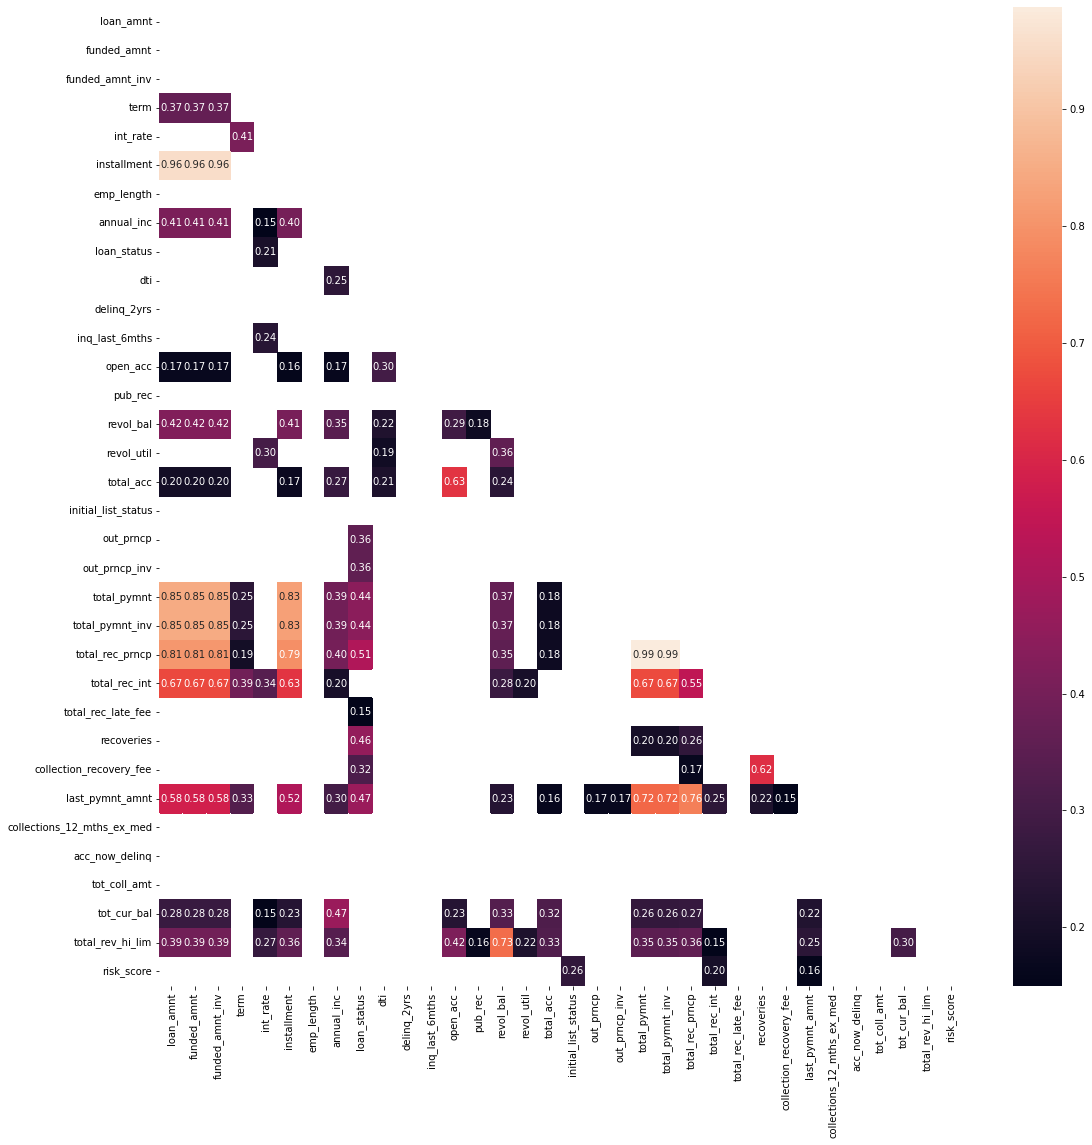

In [27]:
corr = df.corr().abs()
mask = np.tril(corr)
mask = ~((abs(mask) >= 0.15) & (abs(mask) <= 0.99))

plt.figure(figsize=(18,18))
sns.heatmap(corr, annot=True, mask=mask, fmt='.2f')

Dipilih threshold 0.8. Sehingga akan dipilih kolom-kolom yang memiliki korelasi di atas 0.8 dengan variabel lain.

Selain itu, variabel yang memiliki korelasi di atas 0.1 dengan variabel *loan_status* (variabel target) juga akan digunakan untuk pemodelan machine learning.

In [28]:
threshold = 0.8

high_corr = corr[(corr > threshold) & (corr < 0.99)][(corr != np.nan).any(axis=1)]
used_col = set(high_corr[(high_corr > 0.7).any(axis=1)].index)
used_col

{'funded_amnt',
 'funded_amnt_inv',
 'installment',
 'loan_amnt',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp'}

In [29]:
high_corr = corr['loan_status'].loc[lambda x: x >= 0.1].index

for col in set(high_corr):
  used_col.add(col)

for col in df_ob:
  used_col.add(col)

used_col

{'addr_state',
 'annual_inc',
 'collection_recovery_fee',
 'dti',
 'funded_amnt',
 'funded_amnt_inv',
 'grade',
 'home_ownership',
 'installment',
 'int_rate',
 'last_pymnt_amnt',
 'loan_amnt',
 'loan_status',
 'out_prncp',
 'out_prncp_inv',
 'purpose',
 'recoveries',
 'sub_grade',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_late_fee',
 'total_rec_prncp',
 'verification_status'}

In [30]:
for col in df:
  if col not in used_col:
    unused_col.add(col)

unused_col

{'Unnamed: 0',
 'acc_now_delinq',
 'application_type',
 'collections_12_mths_ex_med',
 'delinq_2yrs',
 'desc',
 'earliest_cr_line',
 'emp_length',
 'emp_title',
 'id',
 'initial_list_status',
 'inq_last_6mths',
 'issue_d',
 'last_credit_pull_d',
 'last_pymnt_d',
 'member_id',
 'mths_since_last_delinq',
 'mths_since_last_major_derog',
 'mths_since_last_record',
 'next_pymnt_d',
 'open_acc',
 'policy_code',
 'pub_rec',
 'pymnt_plan',
 'revol_bal',
 'revol_util',
 'risk_score',
 'term',
 'title',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_acc',
 'total_rec_int',
 'total_rev_hi_lim',
 'url',
 'zip_code'}

#### Distribusi

Akan diperiksa apakah variabel yang akan digunakan berdistribusi normal

In [31]:
dist = dict()

for col in used_col:
  if df[col].dtypes != 'object':
    stat, p = shapiro(df[col])
    if p > 0.05:
      dist[col] = [stat, p, 'NORMAL']
    else:
      dist[col] = [stat, p, 'TIDAK NORMAL']

pd.DataFrame(dist, index=['Statistic', 'p-value', 'Distribusi']).transpose()

/usr/local/lib/python3.8/dist-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Statistic,p-value,Distribusi
last_pymnt_amnt,0.874333,0.0,TIDAK NORMAL
int_rate,0.986223,0.0,TIDAK NORMAL
total_rec_late_fee,0.086201,0.0,TIDAK NORMAL
out_prncp,0.174452,0.0,TIDAK NORMAL
total_rec_prncp,0.94972,0.0,TIDAK NORMAL
dti,0.989863,0.0,TIDAK NORMAL
loan_amnt,0.956513,0.0,TIDAK NORMAL
collection_recovery_fee,0.14829,0.0,TIDAK NORMAL
funded_amnt,0.956513,0.0,TIDAK NORMAL
recoveries,0.244751,0.0,TIDAK NORMAL


## Preprocessing

Data kategorikal akan diubah menjadi numerik dengan one hot encoding.

In [32]:
df_num = df[used_col].select_dtypes(exclude = object).drop('loan_status', 
                                                           axis=1)
df_cat = df[used_col].select_dtypes(include = object)
target = df['loan_status']

df[used_col].shape

(140627, 23)

In [33]:
dum_cat = pd.get_dummies(df_cat)
dum_cat.shape

(140627, 113)

In [34]:
df_num.shape

(140627, 16)

Akan dipisah antara data latih dan data uji.

In [35]:
ml_df = pd.concat([df_num, dum_cat], axis=1)

x_train, x_test, y_train, y_test = train_test_split(ml_df, target,
                                                    test_size=.2)

Setelah dilatih, data numerik sebelumnya pada data latih akan dinormalisasi.

In [36]:
x_train_num = x_train[x_train.columns[:16]].to_numpy()
x_train_cat = x_train[x_train.columns[16:]].to_numpy()

scaler = MinMaxScaler()
scaler.fit(x_train_num)
x_train_num = scaler.transform(x_train_num)

x_train = np.concatenate([x_train_num, x_train_cat], axis=1)
x_train.shape

(112501, 129)

In [37]:
x_test_num = x_test[x_test.columns[:16]].to_numpy()
x_test_cat = x_test[x_test.columns[16:]].to_numpy()

x_test_num = scaler.transform(x_test_num)

x_test = np.concatenate([x_test_num, x_test_cat], axis=1)
x_test.shape

(28126, 129)

## Pemodelan

Model machine learning yang akan digunakan adalah Decision Tree dengan hyperparameter tuning menggunakan GridSearchCV

In [38]:
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [2, 3, 4]}

treeclf = tree.DecisionTreeClassifier()

clf = GridSearchCV(treeclf, param_grid, cv=2, 
                   scoring='accuracy', verbose=3)

clf.fit(x_train, y_train)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END .......criterion=gini, max_depth=2;, score=0.943 total time=   0.4s
[CV 2/2] END .......criterion=gini, max_depth=2;, score=0.942 total time=   0.4s
[CV 1/2] END .......criterion=gini, max_depth=3;, score=0.954 total time=   0.5s
[CV 2/2] END .......criterion=gini, max_depth=3;, score=0.954 total time=   0.6s
[CV 1/2] END .......criterion=gini, max_depth=4;, score=0.977 total time=   0.7s
[CV 2/2] END .......criterion=gini, max_depth=4;, score=0.975 total time=   0.7s
[CV 1/2] END ....criterion=entropy, max_depth=2;, score=0.938 total time=   0.4s
[CV 2/2] END ....criterion=entropy, max_depth=2;, score=0.940 total time=   0.4s
[CV 1/2] END ....criterion=entropy, max_depth=3;, score=0.950 total time=   0.6s
[CV 2/2] END ....criterion=entropy, max_depth=3;, score=0.950 total time=   0.6s
[CV 1/2] END ....criterion=entropy, max_depth=4;, score=0.972 total time=   0.7s
[CV 2/2] END ....criterion=entropy, max_depth=4;,

GridSearchCV(cv=2, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4]},
             scoring='accuracy', verbose=3)

In [39]:
print("Hasil dari GridSearchCV " )
print("\nEstimator terbaik:\n",clf.best_estimator_)
print("\nSkor terbaik:\n",clf.best_score_)
print("\nParameter terbaik:\n",clf.best_params_)

Hasil dari GridSearchCV 

Estimator terbaik:
 DecisionTreeClassifier(max_depth=4)

Skor terbaik:
 0.9762579806778744

Parameter terbaik:
 {'criterion': 'gini', 'max_depth': 4}


[Text(0.6527777777777778, 0.9, 'X[0] <= 0.034\ngini = 0.32\nsamples = 112501\nvalue = [90042, 22459]'),
 Text(0.4166666666666667, 0.7, 'X[4] <= 0.171\ngini = 0.459\nsamples = 34248\nvalue = [12219, 22029]'),
 Text(0.2222222222222222, 0.5, 'X[8] <= 0.146\ngini = 0.237\nsamples = 21896\nvalue = [3013, 18883]'),
 Text(0.1111111111111111, 0.3, 'X[4] <= 0.086\ngini = 0.499\nsamples = 6348\nvalue = [3008, 3340]'),
 Text(0.05555555555555555, 0.1, 'gini = 0.383\nsamples = 4258\nvalue = [1101, 3157]'),
 Text(0.16666666666666666, 0.1, 'gini = 0.16\nsamples = 2090\nvalue = [1907, 183]'),
 Text(0.3333333333333333, 0.3, 'X[6] <= 0.147\ngini = 0.001\nsamples = 15548\nvalue = [5, 15543]'),
 Text(0.2777777777777778, 0.1, 'gini = 0.26\nsamples = 13\nvalue = [2, 11]'),
 Text(0.3888888888888889, 0.1, 'gini = 0.0\nsamples = 15535\nvalue = [3, 15532]'),
 Text(0.6111111111111112, 0.5, 'X[3] <= 0.0\ngini = 0.38\nsamples = 12352\nvalue = [9206, 3146]'),
 Text(0.5555555555555556, 0.3, 'X[9] <= 0.002\ngini = 0.

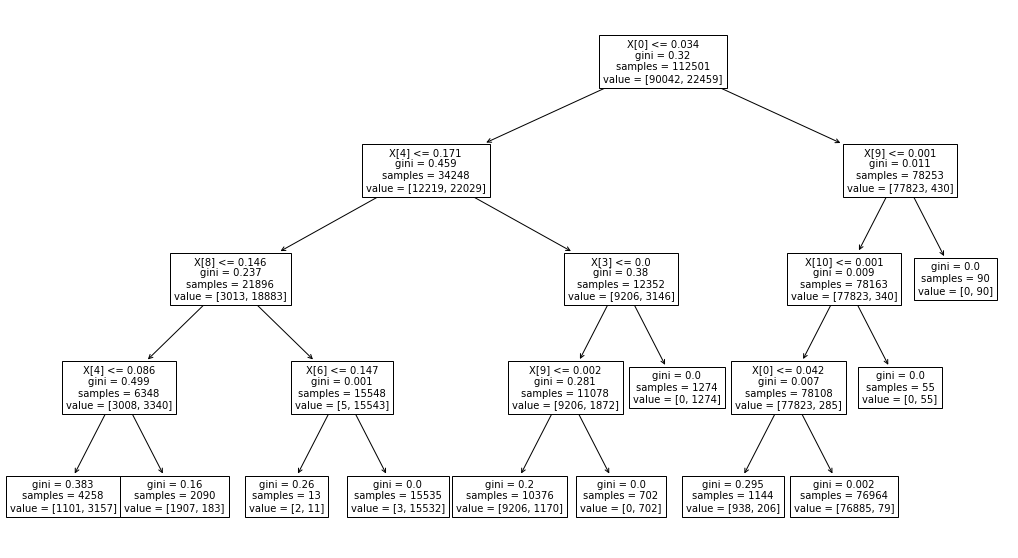

In [40]:
plt.figure(figsize=(18,10))
tree.plot_tree(clf.best_estimator_, fontsize=10)

### Evaluasi Training

In [41]:
print(classification_report(y_train, clf.predict(x_train)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     90042
           1       0.95      0.93      0.94     22459

    accuracy                           0.98    112501
   macro avg       0.97      0.96      0.96    112501
weighted avg       0.98      0.98      0.98    112501



### Evaluasi Testing

In [42]:
print(classification_report(y_test, clf.predict(x_test)))
print(clf.score(x_test, y_test))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     22377
           1       0.95      0.92      0.94      5749

    accuracy                           0.97     28126
   macro avg       0.96      0.95      0.96     28126
weighted avg       0.97      0.97      0.97     28126

0.9741164758586361


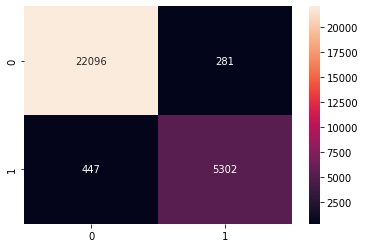

In [43]:
conf = confusion_matrix(y_test, clf.predict(x_test))

sns.heatmap(conf, annot=True, fmt="g")

Model memiliki performa yang sangat baik, baik untuk data latih maupun data uji dengan evaluasi berbagai metrik lebih dari 0,9.

### Menyimpan Model

In [44]:
joblib.dump(clf, 'model.sk')

['model.sk']

In [45]:
clf = joblib.load('model.sk')